# Tweet analysis and topic modelling: University of Tartu vs. Lund University
In this project, I will explore the world of tweet analysis in the case of two European universities: University of Tartu and Lund University. After extracting and pre-processing we are able to analyze the data.Futhermore, we are going to be performing topic modelling on universities' twitter data.

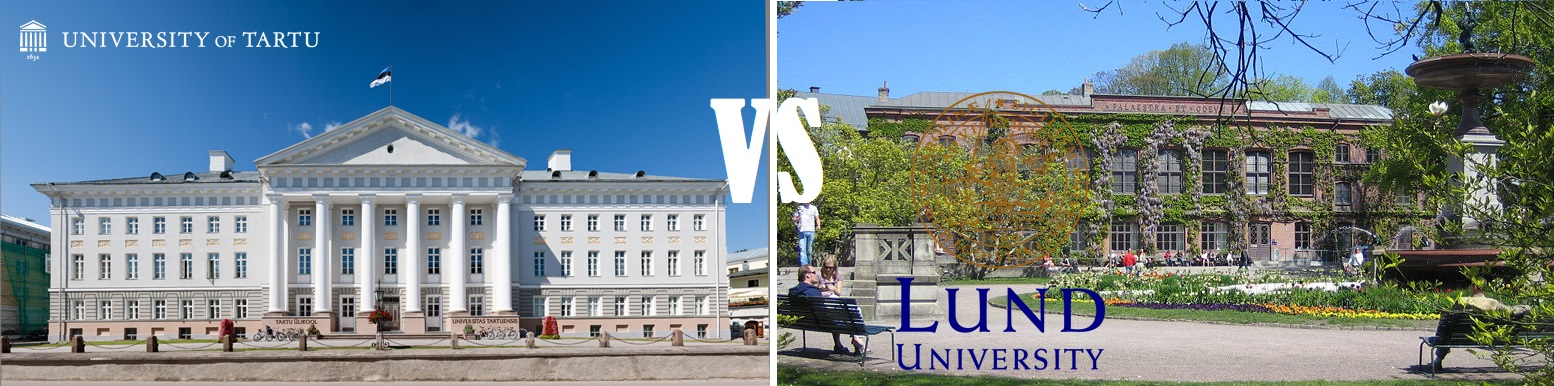

Tweets are able to create NLP-specific problems, because it is the fact that they are shorter texts. There are also many platform-specific contracts that will give you challenges: bets, #hashtag, emoji, links and short hand phrases (ikr?). Can we overcome these challenges and create a useful classifier for these two tweeters? Yeah! Lets start.

To begin, I have to import all the tools I need from scikit-learn. 

## 1. Import modules

In [9]:
# Set seed for reproducibility
import random; random.seed(53)
import pandas as pd
# Import all we need from sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
import csv
import re
import tweepy
from datetime import datetime
import nltk
import requests
import lxml.html as lh
from ipywidgets import *


## 2. Acces to twitter API 
Now that we have the necessary tools ready, I can start coding! The baseline of each application we’ll build today requires using Tweepy to create an API object which we can call functions with. In order create the API object, however, I must first authenticate myself with my developer information.

In [2]:
# Variables that contains the credentials to access Twitter API
access_key = '1198211069887553536-jf2qdnv6irXXXXXXXXXXXXXXX'
access_secret = 'FWMqrUDZhXqkhNB7uexkB5DZXXXXXXXXXXXXXXi'
consumer_key = 'wpHeXH96Oav4nwqwck4YHNVgu'
consumer_secret = 'hiG5cjHXm4D6DvN4PNY2dJZE6K286hFr0mgrtSdmSyDLk3c3I0'


# Setup access to API
def connect_to_twitter_OAuth():
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)

    api = tweepy.API(auth)
    return api


# Create API object
api = connect_to_twitter_OAuth()

## 3. Collect data from twitter
Now, let's extract data about tweets for both universities. In twitter we can collect timeline data of users. The timeline of a certain user are the past tweets that he or she has published or retweeted. We have to know however, that this method that will be used can only return tweets from the last 3200 of a specific user, so if we are gathering posts of a very active account and want tweets from a very long time ago, we will not be able to obtain them.

In [3]:

def get_all_tweets(screen_name):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    alltweets = []
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    alltweets.extend(new_tweets)
    oldest = alltweets[-1].id - 1
    while len(new_tweets) > 0:
        print ("getting tweets before %s" % (oldest))
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
#save most recent tweets
        alltweets.extend(new_tweets)
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

        print ("...%s tweets downloaded from %s so far" % (len(alltweets), screen_name))
    print("Downloading tweets for %s has been finished..." %screen_name)

       #transform the tweepy tweets into a 2D array that will populate the csv	
    for tweet in alltweets:
        if "media" in tweet.entities:
            tweet.entities['media']=1
        else:
            tweet.entities['media']=0
    outtweets = [[screen_name,tweet.id,tweet.text.encode("utf-8"),tweet.created_at,tweet.retweet_count,tweet.favorite_count,tweet.lang,tweet.entities['media']] for tweet in alltweets]
    
    #write the csv	
    with open('%s_tweets.csv' % screen_name, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["author","id","text","date","retweet_count","favorite_count","language","media"])
        writer.writerows(outtweets)
    pass

    #pass in the username of the account you want to download
if __name__ == '__main__':
    get_all_tweets("unitartu")
    get_all_tweets("lunduniversity")  

getting tweets before 1168845182210662400
...400 tweets downloaded from unitartu so far
getting tweets before 1130779264888913919
...600 tweets downloaded from unitartu so far
getting tweets before 1094880422125858815
...800 tweets downloaded from unitartu so far
getting tweets before 1068113630523285504
...1000 tweets downloaded from unitartu so far
getting tweets before 1037633103878123520
...1200 tweets downloaded from unitartu so far
getting tweets before 978889427886989311
...1399 tweets downloaded from unitartu so far
getting tweets before 911124187934285823
...1598 tweets downloaded from unitartu so far
getting tweets before 863686052267139071
...1798 tweets downloaded from unitartu so far
getting tweets before 815259478115356671
...1997 tweets downloaded from unitartu so far
getting tweets before 771242193742737408
...2197 tweets downloaded from unitartu so far
getting tweets before 725711790517174271
...2397 tweets downloaded from unitartu so far
getting tweets before 69295761

With the code we wrote above two csv files were created, one for unitartu and another one is for lunduniversity. Now, let's combine these two files by using pd.concat.

In [6]:
unitartu_tweets=pd.read_csv('unitartu_tweets.csv')
lunduniversity_tweets=pd.read_csv('lunduniversity_tweets.csv')
frames=[unitartu_tweets,lunduniversity_tweets]
final_tweets=pd.concat(frames)
final_tweets.reset_index(inplace=True)

In [9]:
final_tweets

,author,id,text,date,retweet_count,favorite_count,language,media
0,unitartu,1198927870376235009,"b'RT @ivovolt: CfP: Epic, Society and Religion...",2019-11-25 11:34:13,2,0,en,0
1,unitartu,1198927847634743301,b'RT @mkalz: Lecturer of Educational Technolog...,2019-11-25 11:34:08,5,0,en,0
2,unitartu,1198907577872134144,b'RT @evelynuuemaa: #30DayMapChallenge 23. Pop...,2019-11-25 10:13:35,17,0,en,0
3,unitartu,1198906444202029057,b'RT @Bercman_Tech: This week we installed yet...,2019-11-25 10:09:05,2,0,en,0
4,unitartu,1197893247915495424,b'New arrival! https://t.co/YqkyzKNwB3',2019-11-22 15:03:00,1,14,en,0
5,unitartu,1197842410870648832,b'2 guest lectures in #semiotics next week: ht...,2019-11-22 11:41:00,0,2,en,0
6,unitartu,1197833602764955649,"b'A study by our Uku Vainik @ukuv, a research ...",2019-11-22 11:06:00,1,5,en,0
7,unitartu,1197822529785626624,b'Scientists in Estonia and Finland have publi...,2019-11-22 10:22:00,0,4,en,0
8,unitartu,1197805573997256704,"b""RT @errnews: Tartu's Christmas village opens...",2019-11-22 09:14:37,3,0,fr,0
9,unitartu,1197805397840666626,b'RT @evelynuuemaa: #30DayMapChallenge 21. Env...,2019-11-22 09:13:55,3,0,en,0


## 4. Basic Data Analysis
Before I start doing main goal of my project, I want to do some basic analysis on this data. Let's try to answer the following questions:

***1. What day of the week do shared tweets attract more attention for each university?***

***2. Which words were used most in shared tweets?***

***3. Which hashtags do universities use mostly?***

***4. What is the relationship between the number of likes of tweets and published time?***

***5. Which university is more active in summer holidays?***




### 4.1 What day of the week do shared tweets attract more attention for each university?
For this task, I will use datetime function of Python for defining weekday.

In [10]:
import calendar
time=[]
week_day=[]
for i in final_tweets['date']:
    date_time_obj = datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
    week_day.append(calendar.day_name[date_time_obj.weekday()])
    time.append(date_time_obj.time())
    
final_tweets['time']=time
final_tweets['week_day']=week_day

In [11]:
final_tweets.head()

,author,id,text,date,retweet_count,favorite_count,language,media,time,week_day
0,unitartu,1198927870376235009,"b'RT @ivovolt: CfP: Epic, Society and Religion...",2019-11-25 11:34:13,2,0,en,0,11:34:13,Monday
1,unitartu,1198927847634743301,b'RT @mkalz: Lecturer of Educational Technolog...,2019-11-25 11:34:08,5,0,en,0,11:34:08,Monday
2,unitartu,1198907577872134144,b'RT @evelynuuemaa: #30DayMapChallenge 23. Pop...,2019-11-25 10:13:35,17,0,en,0,10:13:35,Monday
3,unitartu,1198906444202029057,b'RT @Bercman_Tech: This week we installed yet...,2019-11-25 10:09:05,2,0,en,0,10:09:05,Monday
4,unitartu,1197893247915495424,b'New arrival! https://t.co/YqkyzKNwB3',2019-11-22 15:03:00,1,14,en,0,15:03:00,Friday


Let's see which day of the week do shared tweets attract more attention for each university. Attraction means the sum of the number of favorites and retweets and then we have to divide it by the count of ids.

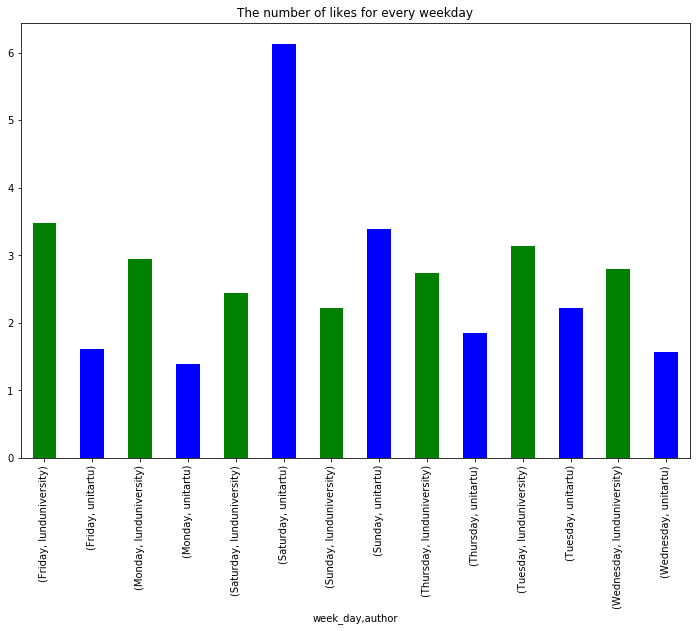

In [205]:
s=(final_tweets.groupby(['week_day','author'])['favorite_count'].sum())/(final_tweets.groupby(['week_day','author'])['id'].count())
s.plot(title='The number of likes for every weekday',figsize=(12,8),color=['green','blue'],kind='bar')

As you see from the bargraph, universitytartu have got the most favorite on Saturday posts, on the other hand lunduniversity followers were active on Fridays. Now let's see how many likes have they got between two date. I will get an introduction to IPython widgets. These are tools that allow us to build interactivity into our notebooks often with a single line of code. These widgets are very useful for data exploration and analysis, for example, selecting certain data or updating charts. In effect, Widgets allow you to make Jupyter Notebooks into an interactive dashboard instead of a static document.

In [15]:
final_tweets['date'] = pd.to_datetime(final_tweets['date'])
final_tweets.set_index('date', inplace=True)

In [16]:
print('*'*80)
print("Please, choose date interval to see some statistical information about tweets. ")
def print_tweets_published(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    stat_df = final_tweets.loc[(final_tweets.index >= start_date) & (final_tweets.index <= end_date)].copy()
    total_likes_ut = stat_df.loc[stat_df['author']=='unitartu', ['favorite_count']].sum()[0]
    total_retweet_ut = stat_df.loc[stat_df['author']=='unitartu', ['retweet_count']].sum()[0]
    num_tweets_ut = stat_df.loc[stat_df['author']=='unitartu'].count()[0]
    authors=stat_df['author'].unique()
    ut=authors[0]
    lu=authors[1]
    total_likes_lu = stat_df.loc[stat_df['author']=='lunduniversity', ['favorite_count']].sum()[0]
    total_retweet_lu = stat_df.loc[stat_df['author']=='lunduniversity', ['retweet_count']].sum()[0]
    num_tweets_lu = stat_df.loc[stat_df['author']=='lunduniversity'].count()[0]
    authors=stat_df['author'].unique()
    print('*'*80)
    print(f'{ut} published {num_tweets_ut} tweets between {start_date.date()} and {end_date.date()}.')
    print(f'These tweets have got {total_likes_ut} likes and retweeted by {total_retweet_ut} totally.')
    print('-' * 80)
    print(f'On the other hand, {lu} published {num_tweets_lu} tweets during this time.')
    print(f'These tweets have got {total_likes_lu} likes and retweeted by {total_retweet_lu}.')
    print('*'*80)
    
_ = interact(print_tweets_published,
             start_date=widgets.DatePicker(value=pd.to_datetime('2011-01-01')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01')))

********************************************************************************
Please, choose date interval to see some statistical information about tweets. 


interactive(children=(DatePicker(value=Timestamp('2011-01-01 00:00:00'), description='start_date'), DatePicker…

For this function, we use a Dropdown and a DatePicker to plot one column cumulatively up to a certain time. Instead of having to write this ourselves, we can just let ipywidgets do all the work!

In [335]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
def plot_up_to(column, date):
    date = pd.Timestamp(date)
    plot_df = final_tweets.loc[final_tweets.index <= date].copy()
    plot_df[column].cumsum().iplot(mode='markers+lines', 
                                   xTitle='date',
                                   yTitle=column, 
                                  title=f'Cumulative {column.title()} Until {date.date()}')
    
_ = interact(plot_up_to, column=widgets.Dropdown(options=('favorite_count','retweet_count')), 
             date = widgets.DatePicker(value=pd.to_datetime('2011-01-01')))

interactive(children=(Dropdown(description='column', options=('favorite_count', 'retweet_count'), value='favor…

### 4.2 Which word and hashtag were used most in shared tweets?
For answering this question, we will extract the words and for this we'll use nltk – the Natural Language Toolkit. We'll start by tokenizing the text, that is, remove everything that isn't a word (whitespace, punctuation, etc.) and then split the text into a list of words.

In [377]:
for i in range(0,len(final_tweets.text)):
    final_tweets.text[i]=final_tweets.text[i][1:]

In [385]:
tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
final_tweets['text'].apply(tokenizer.tokenize)

0                [New, arrival, https, t, co, YqkyzKNwB3]
1       [2, guest, lectures, in, semiotics, next, week...
2       [A, study, by, our, Uku, Vainik, ukuv, a, rese...
3       [Scientists, in, Estonia, and, Finland, have, ...
4       [RT, errnews, Tartu, s, Christmas, village, op...
5       [RT, evelynuuemaa, 30DayMapChallenge, 21, Envi...
6       [This, happened, to, our, student, Murat, in, ...
7       [RT, UniTartuCS, Unitartucs, students, Jens, S...
8                           [Alliance4lifeEu, Thank, you]
9       [Yesterday, our, geographers, and, Regio, pres...
10      [RT, poli_com, CfP, H2020, ERA, Chair, in, e, ...
11      [Today, the, Bank, of, Estonia, and, the, Esto...
12      [In, the, fresh, 2020, THEunirankings, 4, new,...
13      [If, you, want, to, be, a, part, of, a, startu...
14                             [evelynuuemaa, Thank, you]
15         [Estonia, is, small, https, t, co, B8dqBMqBXP]
16      [evelynuuemaa, So, cool, May, we, share, it, o...
17      [Prof,

As you see from the above, we have a list for every tweet. But it is not useful for us, for this reason I will use itertools for combinening them under a list.

In [395]:
import itertools
tokens=tokens.tolist()
tokens=(list(itertools.chain.from_iterable(tokens)))

In [392]:
tokens

['New',
 'arrival',
 'https',
 't',
 'co',
 'YqkyzKNwB3',
 '2',
 'guest',
 'lectures',
 'in',
 'semiotics',
 'next',
 'week',
 'https',
 't',
 'co',
 'Dm434MrZ3s',
 'A',
 'study',
 'by',
 'our',
 'Uku',
 'Vainik',
 'ukuv',
 'a',
 'research',
 'fellow',
 'of',
 'experimental',
 'psychology',
 'https',
 't',
 'co',
 'lLyEIJZvuj',
 'Scientists',
 'in',
 'Estonia',
 'and',
 'Finland',
 'have',
 'published',
 'the',
 'first',
 'research',
 'from',
 'their',
 'new',
 'facility',
 'within',
 'Sweden',
 'xe2',
 'x80',
 'x99s',
 'famous',
 'xe2',
 'x80',
 'xa6',
 'https',
 't',
 'co',
 '4yDHZLKpvz',
 'RT',
 'errnews',
 'Tartu',
 's',
 'Christmas',
 'village',
 'opens',
 'on',
 'Dec',
 '1',
 'tartulinn',
 'estonia',
 'nhttps',
 't',
 'co',
 'rGlgXOnLAh',
 'RT',
 'evelynuuemaa',
 '30DayMapChallenge',
 '21',
 'Environment',
 'Wetlands',
 'in',
 'most',
 'parts',
 'of',
 'the',
 'world',
 'lost',
 'environments',
 'xf0',
 'x9f',
 'x8c',
 'x8d',
 'xf0',
 'x9f',
 'x92',
 'xa6',
 'Estonia',
 'has',
 '

OK! We're nearly there. Note that in the above 'Arrival' has a capital 'A' and that in other places it may not, but both 'Arrival' and 'arrival' should be counted as the same word. For this reason, we should build a list of all words in Moby Dick in which all capital letters have been made lower case.

In [396]:
# A new list to hold the lowercased words
words = []

# Looping through the tokens and make them lower case
for word in tokens:
    words.append(word.lower())

# Printing out the first 8 words / tokens 
print(words[:8])

['new', 'arrival', 'https', 't', 'co', 'yqkyzknwb3', '2', 'guest']


It is common practice to remove words that appear a lot in the English language such as 'the', 'of' and 'a' because they're not so interesting. Such words are known as stop words. The package nltk includes a good list of stop words in English that we can use.

In [400]:
nltk.download('stopwords')
sw = nltk.corpus.stopwords.words('english')

# Printing out the first eight stop words
print(sw[:8])
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves']
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'suc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nijat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


But in our tweets some words such as (https, co, xt2 etc.) will affect our answer and these words are not exist in the stop list. That is the case and we have to add our stopwords to the list for the best accuracy. Also it will be better if we insert university names into our list.

In [411]:
newStopWords = ['http','https','x80','xa6','rt','co','xe2','amp','x9f','xf0','xc3','lunduniversity','unitartu']
sw.extend(newStopWords)

We now want to create a new list with all words in tweets, except those that are stop words (that is, those words listed in sw). One way to get this list is to loop over all elements of words and add each word to a new list if they are not in sw.

In [412]:
words_ns = []

# Appending to words_ns all words that are in words but not in sw
for word in words:
    if word not in sw:
        words_ns.append(word)

# Printing the first 5 words_ns to check that stop words are gone
print(words_ns[:3])

['new', 'arrival', 'yqkyzknwb3']


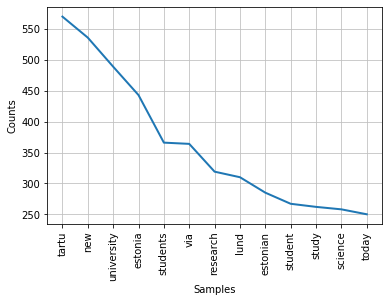

In [416]:
%matplotlib inline

# Creating the word frequency distribution
freqdist = nltk.FreqDist(words_ns)

# Plotting the word frequency distribution
freqdist.plot(13)

As we see, "tartu" is the most used word among the all tweets, universities have used "new" approximately 530 times in their tweets. Moreover, academic words like "science", "students", "research" are the popular words.

### 4.3. Which hashtags do universities use mostly?

As a quick overview the re package can be used to extract or replace certain patterns in string data in Python. You can use this package for anything from removing sensitive information like dates of birth and account numbers, to extracting all sentences that end in a :), to see what is making people happy.

In this tutorial we are going to be using this package to extract from each tweet:

what hashtags are being used (if any)
Functions to extract each of these three things are below.

In [11]:
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet) 

In [12]:
final_tweets['hashtags'] = final_tweets.text.apply(find_hashtags)

In [13]:
final_tweets.head()

,index,author,id,text,date,retweet_count,favorite_count,language,media,time,week_day,hashtags
0,0,unitartu,1198927870376235009,"b'RT @ivovolt: CfP: Epic, Society and Religion...",2019-11-25 11:34:13,2,0,en,0,11:34:13,Monday,[]
1,1,unitartu,1198927847634743301,b'RT @mkalz: Lecturer of Educational Technolog...,2019-11-25 11:34:08,4,0,en,0,11:34:08,Monday,"[#TEL, #jobs, #postdoc, #edtech, #edutech]"
2,2,unitartu,1198907577872134144,b'RT @evelynuuemaa: #30DayMapChallenge 23. Pop...,2019-11-25 10:13:35,17,0,en,0,10:13:35,Monday,[]
3,3,unitartu,1198906444202029057,b'RT @Bercman_Tech: This week we installed yet...,2019-11-25 10:09:05,2,0,en,0,10:09:05,Monday,[]
4,4,unitartu,1197893247915495424,b'New arrival! https://t.co/YqkyzKNwB3',2019-11-22 15:03:00,1,14,en,0,15:03:00,Friday,[]


So far we have extracted who was retweeted, who was mentioned and the hashtags into their own separate columns. Now lets look at these further. We want to know who is highly retweeted, who is highly mentioned and what popular hashtags are going round.

In the following section we will perform an analysis on the hashtags only. We will leave it up to you to come back and repeat a similar analysis on the mentioned and retweeted columns.

First we will select the column of hashtags from the dataframe, and take only the rows where there actually is a hashtag

In [15]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = final_tweets.loc[
                       final_tweets.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]
hashtags_list_df.head()

,hashtags
1,"[#TEL, #jobs, #postdoc, #edtech, #edutech]"
5,[#semiotics]
8,[#estonia]
10,[#shortstory]
11,[#Unitartucs]


To see which hashtags were popular we will need to flatten out this dataframe. Currently each row contains a list of multiple values. The next block of code will make a new dataframe where we take all the hashtags in hashtags_list_df but give each its own row.



In [16]:
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
flattened_hashtags_df.head()

,hashtag
0,#TEL
1,#jobs
2,#postdoc
3,#edtech
4,#edutech


Now, as we did with the full tweets before, you should find the number of unique rows in this dataframe. Before this was the unique number of tweets, now the unique number of hashtags.



In [17]:
# number of unique hashtags
flattened_hashtags_df['hashtag'].unique().size

# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)    

Once you have done that, plot the distribution in how often these hashtags appear



In [20]:
import numpy as np
import matplotlib.pyplot as plt
# number of times each hashtag appears
counts = flattened_hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

<Figure size 640x480 with 1 Axes>

Now lets say that we want to find which of our hashtags are correlated with each other. To do this we will need to turn the text into numeric form. It is possible to do this by transforming from a list of hashtags to a vector representing which hashtags appeared in which rows. For example if our available hashtags were the set [#education, #jobs, #tartu], then the tweet ‘#education, #jobs’ would be [0,1,1,0] in vector form.

We will now apply this method to our hashtags column of df. Before we do this we will want to limit to hashtags that appear enough times to be correlated with other hashtags. We can’t correlate hashtags which only appear once, and we don’t want hashtags that appear a low number of times since this could lead to spurious correlations.

In the following code block we are going to find what hashtags meet a minimum appearance threshold. These are going to be the hashtags we will look for correlations between

In [21]:
# take hashtags which appear at least this amount of times
min_appearance = 10
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

Next we are going to create a new column in hashtags_df which filters the hashtags to only the popular hashtags. We will also drop the rows where no popular hashtags appear.

In [23]:
# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]
popular_hashtags_list_df.head()

,hashtags,popular_hashtags
5,[#semiotics],[#semiotics]
8,[#estonia],[#estonia]
19,[#Estonia],[#Estonia]
24,"[#obesity, #addictions]",[#obesity]
26,"[#Latvia, #Eesti]",[#Latvia]


Next we want to vectorise our the hashtags in each tweet like mentioned above. We do this using the following block of code to create a dataframe where the hashtags contained in each row are in vector form.

In [26]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

In the next code block we will use the pandas.DataFrame inbuilt method to find the correlation between each column of the dataframe and thus the correlation between the different hashtags appearing in the same tweets.

We will use the seaborn package that we imported earlier to plot the correlation matrix as a heatmap

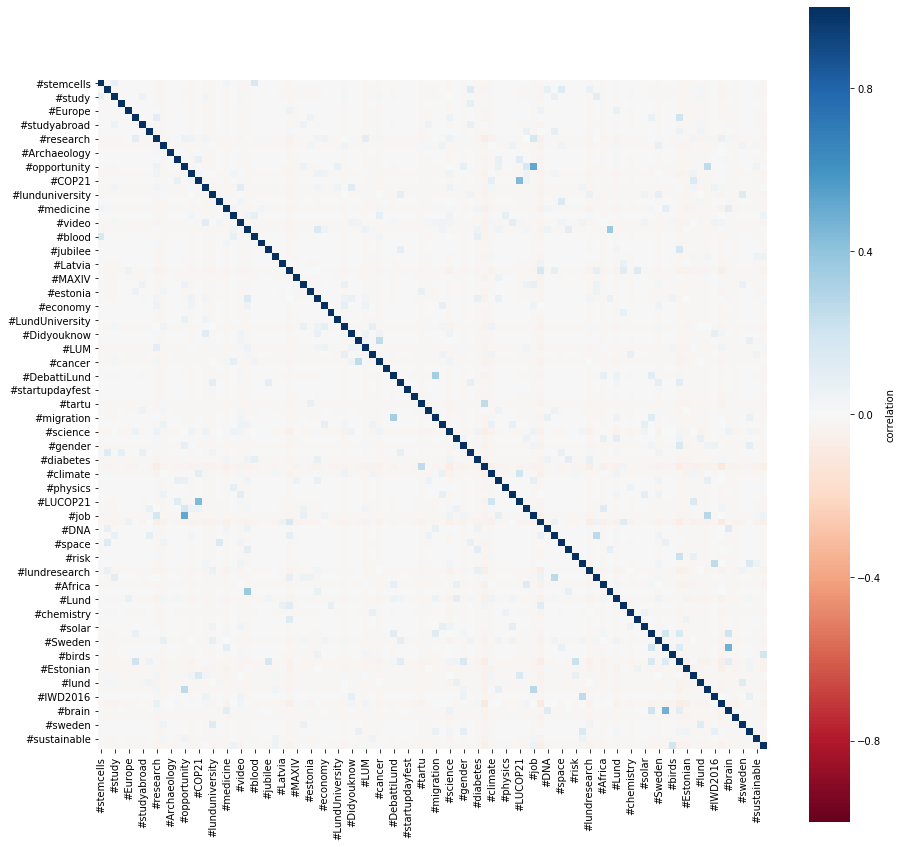

In [33]:
import seaborn as sns
# calculate the correlation matrix
correlations = hashtag_matrix.corr()
# plot the correlation matrix
plt.figure(figsize=(15,15))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

### 4.4 What is the relationship between the number of likes of tweets and other variables?

It is interesting to see that,  which type of tweets is common for every part of the day according to their sentiment value. Then, eventually we will look at the relationhsip among the all variables by using correlation heat-map.

Let's begin with split hours from tweets' published date and assign it to names of day parts. We will divided day into 6 parts and will use numbers for it: 

Early morning 5 ~ 8

Morning 8 ~ 11

Late morning 11 ~ 12 

Early afternoon 13 ~ 15

Late afternoon  15 ~ 17

Early evening 17 ~ 19

Late evening 19 ~ 21

Night 21 ~ 4

In [17]:
daypart=[]
for i in final_tweets.time:
    if (i.hour)>=5 and i.hour<8:
        daypart.append('Early Morning')
    elif i.hour>=8 and i.hour<11:
        daypart.append('Morning')
    elif i.hour>=11 and i.hour<12:
        daypart.append('Late Morning')
    elif i.hour>=12 and i.hour<15:
        daypart.append('Early Afternoon')
    elif i.hour>=15 and i.hour<17:
        daypart.append('Late Afternoon')
    elif i.hour>=17 and i.hour<19:
        daypart.append('Early Evening')
    elif i.hour>=19 and i.hour<21:
        daypart.append('Late Evening')
    elif i.hour>=21 or i.hour<5:
        daypart.append('Night')
final_tweets['day_part']=daypart

In [20]:
final_tweets.head()

,author,id,text,date,retweet_count,favorite_count,language,media,time,week_day,day_part
0,unitartu,1198927870376235009,"b'RT @ivovolt: CfP: Epic, Society and Religion...",2019-11-25 11:34:13,2,0,en,0,11:34:13,Monday,Late Morning
1,unitartu,1198927847634743301,b'RT @mkalz: Lecturer of Educational Technolog...,2019-11-25 11:34:08,5,0,en,0,11:34:08,Monday,Late Morning
2,unitartu,1198907577872134144,b'RT @evelynuuemaa: #30DayMapChallenge 23. Pop...,2019-11-25 10:13:35,17,0,en,0,10:13:35,Monday,Morning
3,unitartu,1198906444202029057,b'RT @Bercman_Tech: This week we installed yet...,2019-11-25 10:09:05,2,0,en,0,10:09:05,Monday,Morning
4,unitartu,1197893247915495424,b'New arrival! https://t.co/YqkyzKNwB3',2019-11-22 15:03:00,1,14,en,0,15:03:00,Friday,Late Afternoon


We have dayparts for each tweet, now let's learn sentiment values of tweets by using textblob

In [33]:
from textblob import TextBlob
l=[]
for tweet in final_tweets.text:
    analysis = TextBlob(tweet)
    if analysis.sentiment[0]>0:
        l.append('Positive')
    elif analysis.sentiment[0]==0:
        l.append('Neutral')
    else:
        l.append('Negative')
final_tweets['sentiment']=l

In [34]:
final_tweets

,Unnamed: 0,author,id,text,date,retweet_count,favorite_count,language,media,time,week_day,day_part,sentiment
0,0,unitartu,1198927870376235009,"b'RT @ivovolt: CfP: Epic, Society and Religion...",2019-11-25 11:34:13,2,0,en,0,11:34:13,Monday,Late Morning,Positive
1,1,unitartu,1198927847634743301,b'RT @mkalz: Lecturer of Educational Technolog...,2019-11-25 11:34:08,5,0,en,0,11:34:08,Monday,Late Morning,Positive
2,2,unitartu,1198907577872134144,b'RT @evelynuuemaa: #30DayMapChallenge 23. Pop...,2019-11-25 10:13:35,17,0,en,0,10:13:35,Monday,Morning,Neutral
3,3,unitartu,1198906444202029057,b'RT @Bercman_Tech: This week we installed yet...,2019-11-25 10:09:05,2,0,en,0,10:09:05,Monday,Morning,Positive
4,4,unitartu,1197893247915495424,b'New arrival! https://t.co/YqkyzKNwB3',2019-11-22 15:03:00,1,14,en,0,15:03:00,Friday,Late Afternoon,Positive
5,5,unitartu,1197842410870648832,b'2 guest lectures in #semiotics next week: ht...,2019-11-22 11:41:00,0,2,en,0,11:41:00,Friday,Late Morning,Neutral
6,6,unitartu,1197833602764955649,"b'A study by our Uku Vainik @ukuv, a research ...",2019-11-22 11:06:00,1,5,en,0,11:06:00,Friday,Late Morning,Positive
7,7,unitartu,1197822529785626624,b'Scientists in Estonia and Finland have publi...,2019-11-22 10:22:00,0,4,en,0,10:22:00,Friday,Morning,Positive
8,8,unitartu,1197805573997256704,"b""RT @errnews: Tartu's Christmas village opens...",2019-11-22 09:14:37,3,0,fr,0,09:14:37,Friday,Morning,Neutral
9,9,unitartu,1197805397840666626,b'RT @evelynuuemaa: #30DayMapChallenge 21. Env...,2019-11-22 09:13:55,3,0,en,0,09:13:55,Friday,Morning,Positive


Now can we see relationship among the variables in our dataset? Surely, no. Because the most of our variables are categorical and we can not use them in regression. For this reason, we have to add indicator value to our dataset. An indicator variable (or dummy variable) is a numerical variable used to label categories. They are called 'dummies' because the numbers themselves don't have inherent meaning. We see the column "sentiment" has three unique values. As I mentioned, regression doesn't understand words, only numbers. To use this attribute in regression analysis, we convert "sentimetn" into indicator variables. We will use the panda's method 'get_dummies' to assign numerical values to different categories of sentiment.

In [35]:
dummy_variable_1 = pd.get_dummies(final_tweets["sentiment"])
dummy_variable_1.head()

,Negative,Neutral,Positive
0,0,0,1
1,0,0,1
2,0,1,0
3,0,0,1
4,0,0,1


We will now insert this column back into our original dataset and will drop sentiment column.

In [36]:
# merge data frame "df" and "dummy_variable_1" 
final_tweets = pd.concat([final_tweets, dummy_variable_1], axis=1)
final_tweets.drop("sentiment", axis = 1, inplace=True)
final_tweets.head()

,Unnamed: 0,author,id,text,date,retweet_count,favorite_count,language,media,time,week_day,day_part,Negative,Neutral,Positive
0,0,unitartu,1198927870376235009,"b'RT @ivovolt: CfP: Epic, Society and Religion...",2019-11-25 11:34:13,2,0,en,0,11:34:13,Monday,Late Morning,0,0,1
1,1,unitartu,1198927847634743301,b'RT @mkalz: Lecturer of Educational Technolog...,2019-11-25 11:34:08,5,0,en,0,11:34:08,Monday,Late Morning,0,0,1
2,2,unitartu,1198907577872134144,b'RT @evelynuuemaa: #30DayMapChallenge 23. Pop...,2019-11-25 10:13:35,17,0,en,0,10:13:35,Monday,Morning,0,1,0
3,3,unitartu,1198906444202029057,b'RT @Bercman_Tech: This week we installed yet...,2019-11-25 10:09:05,2,0,en,0,10:09:05,Monday,Morning,0,0,1
4,4,unitartu,1197893247915495424,b'New arrival! https://t.co/YqkyzKNwB3',2019-11-22 15:03:00,1,14,en,0,15:03:00,Friday,Late Afternoon,0,0,1


Then, let's learn which part of the day was the best to share the post for each uiversity. In this case, we will usegroupedThe "groupby" method groups data by different categories. The data is grouped based on one or several variables and analysis is performed on the individual groups.

For example, let's group by the variable "day_part". We see that there are 8 different categories of day parts. But to do it for each university let's seperate our dataset.

In [ ]:
unitartu=final_tweets.loc[final_tweets['author']=='unitartu']
lunduniversity=final_tweets.loc[final_tweets['author']=='lunduniversity']

unitartu.drop(columns='Unnamed: 0',inplace=True)
lunduniversity.drop(columns='Unnamed: 0',inplace=True)

In [89]:
unitartu['day_part'].value_counts()

Morning            1294
Early Morning       745
Early Afternoon     684
Late Morning        316
Late Afternoon       79
Early Evening        39
Late Evening         37
Night                15
Name: day_part, dtype: int64

In [90]:
lunduniversity['day_part'].value_counts()

Early Afternoon    988
Morning            947
Early Morning      403
Late Morning       315
Late Afternoon     275
Late Evening       142
Early Evening      134
Night               20
Name: day_part, dtype: int64

We can convert the series to a Dataframe as follows :

In [91]:
tartu_day_part_count=unitartu['day_part'].value_counts().to_frame()

In [92]:
lund_day_part_count=lunduniversity['day_part'].value_counts().to_frame()

Now let's rename the index

In [94]:
tartu_day_part_count.index.name = 'names'
tartu_day_part_count

,day_part
names,
Morning,1294
Early Morning,745
Early Afternoon,684
Late Morning,316
Late Afternoon,79
Early Evening,39
Late Evening,37
Night,15


In [95]:
lund_day_part_count.index.name = 'names'
lund_day_part_count

,day_part
names,
Early Afternoon,988
Morning,947
Early Morning,403
Late Morning,315
Late Afternoon,275
Late Evening,142
Early Evening,134
Night,20


As wee see, University of Tartu's page has shared the most tweets in the morning, as well as, Lund University has published them in the Early Afternoon, mostly. The "groupby" method groups data by different categories. The data is grouped based on one or several variables and analysis is performed on the individual groups.

In [96]:
unitartu['day_part'].unique()

array(['Late Morning', 'Morning', 'Late Afternoon', 'Early Afternoon',
       'Early Morning', 'Night', 'Early Evening', 'Late Evening'],
      dtype=object)

If we want to know, on average, which type of drive wheel is most valuable, we can group "day_part" and then average them.

We can select the columns 'day_part','week_day' and 'favorite_count', then assign it to the variable "df_group_one".

In [97]:
tartu_df_group_one = unitartu[['day_part','week_day','favorite_count']]
lund_df_group_one = lunduniversity[['day_part','week_day','favorite_count']]

In [98]:
tartu_df_group_one = tartu_df_group_one.groupby(['day_part'],as_index=False).mean()
tartu_df_group_one.sort_values('favorite_count',ascending=False)

,day_part,favorite_count
2,Early Morning,2.041611
5,Late Morning,1.905063
0,Early Afternoon,1.874269
3,Late Afternoon,1.835443
6,Morning,1.722566
1,Early Evening,1.205128
4,Late Evening,0.675676
7,Night,0.066667


In [99]:
lund_df_group_one = lund_df_group_one.groupby(['day_part'],as_index=False).mean()
lund_df_group_one.sort_values('favorite_count',ascending=False)

,day_part,favorite_count
7,Night,5.150000
6,Morning,3.087645
0,Early Afternoon,3.082996
3,Late Afternoon,2.970909
1,Early Evening,2.932836
5,Late Morning,2.888889
2,Early Morning,2.821340
4,Late Evening,2.169014


It seems that, tweets which published by unitartu in mornings got the most likes, conversely for lunduniversity it is night. By the way, night's posts had got the least likes in unitartu. We can also group with multiple variables. For example, let's group by both 'day_part' and 'Negative'. This groups the dataframe by the unique combinations 'day_part' and 'Negative'. We can store the results in the variable 'grouped_test1'.

In [104]:
# grouping results
tartu_df_gptest = unitartu[['day_part','Negative','favorite_count']]
tartu_grouped_test1 = tartu_df_gptest.groupby(['day_part','Negative'],as_index=False).mean()
tartu_grouped_test1.sort_values('favorite_count',ascending=False)

,day_part,Negative,favorite_count
4,Early Morning,0,2.056865
11,Late Morning,1,1.920000
10,Late Morning,0,1.903780
0,Early Afternoon,0,1.895455
6,Late Afternoon,0,1.881579
12,Morning,0,1.761905
5,Early Morning,1,1.583333
1,Early Afternoon,1,1.291667
2,Early Evening,0,1.270270
13,Morning,1,1.092105


In [106]:
# grouping results
lund_df_gptest = lunduniversity[['day_part','Negative','favorite_count']]
lund_grouped_test1 = lund_df_gptest.groupby(['day_part','Negative'],as_index=False).mean()
lund_grouped_test1.sort_values('favorite_count',ascending=False)

,day_part,Negative,favorite_count
14,Night,0,5.150000
5,Early Morning,1,3.714286
1,Early Afternoon,1,3.428571
11,Late Morning,1,3.366667
12,Morning,0,3.188289
2,Early Evening,0,3.082645
0,Early Afternoon,0,3.056645
6,Late Afternoon,0,2.992188
10,Late Morning,0,2.838596
4,Early Morning,0,2.772251


This grouped data is much easier to visualize when it is made into a pivot table. A pivot table is like an Excel spreadsheet, with one variable along the column and another along the row. We can convert the dataframe to a pivot table using the method "pivot " to create a pivot table from the groups.

In this case, we will leave the day_part variable as the rows of the table, and pivot Negative to become the columns of the table:

In [107]:
tartu_grouped_pivot = tartu_grouped_test1.pivot(index='day_part',columns='Negative')
tartu_grouped_pivot

favorite_count          
Negative                     0         1
day_part                                
Early Afternoon       1.895455  1.291667
Early Evening         1.270270  0.000000
Early Morning         2.056865  1.583333
Late Afternoon        1.881579  0.666667
Late Evening          0.685714  0.500000
Late Morning          1.903780  1.920000
Morning               1.761905  1.092105
Night                 0.000000  1.000000

In [109]:
lund_grouped_pivot = lund_grouped_test1.pivot(index='day_part',columns='Negative')
lund_grouped_pivot

favorite_count          
Negative                     0         1
day_part                                
Early Afternoon       3.056645  3.428571
Early Evening         3.082645  1.538462
Early Morning         2.772251  3.714286
Late Afternoon        2.992188  2.684211
Late Evening          2.261194  0.625000
Late Morning          2.838596  3.366667
Morning               3.188289  1.934211
Night                 5.150000       NaN

Woow! We can see interesting points! If unitartu has shared something negative in early evening, it has received approximately no likes, on the contrary, negative tweets that has been shared in early morning has the maximum likes. Another interesting point is that, as we see above, negative tweets have been liked 3 times more than positive ones which have been published in late afternoon. 

When we look at the lunduniversity case, we can notice that people have liked negative posts more than positives which have posted in Early Morning and Late Morning. Unlike unitartu, positive and neutral tweets have been liked more than negative ones in late afternoon.
Now let's use a heat map to visualize the relationship between day_part vs negative sentiment value.

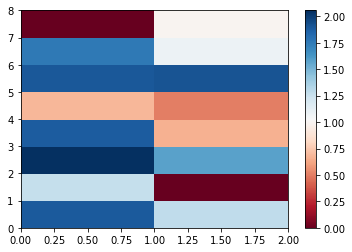

In [110]:
plt.pcolor(tartu_grouped_pivot, cmap='RdBu')
plt.colorbar()
plt.show()

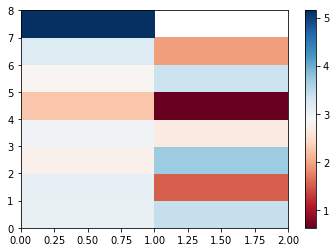

In [111]:
plt.pcolor(lund_grouped_pivot, cmap='RdBu')
plt.colorbar()
plt.show()

The heatmap plots the target variable  proportional to colour with respect to the variables 'day part' and 'negative' in the vertical and horizontal axis respectively. This allows us to visualize how the price is related to 'day part' and 'negative'.
The default labels convey no useful information to us. Let's change that:

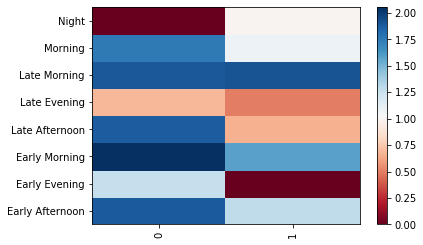

In [113]:
fig, ax = plt.subplots()
im = ax.pcolor(tartu_grouped_pivot, cmap='RdBu')

#label names
row_labels = tartu_grouped_pivot.columns.levels[1]
col_labels = tartu_grouped_pivot.index

#move ticks and labels to the center
ax.set_xticks(np.arange(tartu_grouped_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(tartu_grouped_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

fig.colorbar(im)
plt.show()

For lunduniversity:

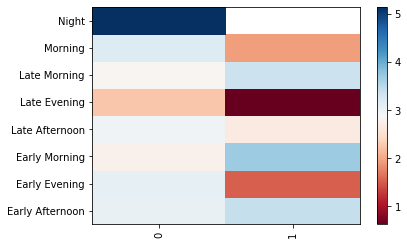

In [114]:
fig, ax = plt.subplots()
im = ax.pcolor(lund_grouped_pivot, cmap='RdBu')

#label names
row_labels = lund_grouped_pivot.columns.levels[1]
col_labels = lund_grouped_pivot.index

#move ticks and labels to the center
ax.set_xticks(np.arange(lund_grouped_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(lund_grouped_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

fig.colorbar(im)
plt.show()

 ### 4.5 Which university is more active in summer holidays?

For this task, we have to choose these holidays months. For University of Tartu summer holiday is between 
29 June and 30 August, bu for Lund University it is from 9 June to 2 September. We will take these times seperately and visualize it together.

In [119]:
for i in range(0,len(final_tweets)):
    if ((final_tweets['date'][i].month)>6 and (final_tweets['date'][i].day>29) and (final_tweets['date'][i].month)<9 and (final_tweets['date'][i].day<30)):
        print(i)

In [118]:
final_tweets

,date,author,id,text,retweet_count,favorite_count,language,media,time,week_day,sentiment,Early Afternoon,Early Evening,Early Morning,Late Afternoon,Late Evening,Late Morning,Morning,Night
0,2019-11-25 11:34:13,unitartu,1198927870376235009,"b'RT @ivovolt: CfP: Epic, Society and Religion...",2,0,en,0,11:34:13,Monday,Positive,0,0,0,0,0,1,0,0
1,2019-11-25 11:34:08,unitartu,1198927847634743301,b'RT @mkalz: Lecturer of Educational Technolog...,5,0,en,0,11:34:08,Monday,Positive,0,0,0,0,0,1,0,0
2,2019-11-25 10:13:35,unitartu,1198907577872134144,b'RT @evelynuuemaa: #30DayMapChallenge 23. Pop...,17,0,en,0,10:13:35,Monday,Neutral,0,0,0,0,0,0,1,0
3,2019-11-25 10:09:05,unitartu,1198906444202029057,b'RT @Bercman_Tech: This week we installed yet...,2,0,en,0,10:09:05,Monday,Positive,0,0,0,0,0,0,1,0
4,2019-11-22 15:03:00,unitartu,1197893247915495424,b'New arrival! https://t.co/YqkyzKNwB3',1,14,en,0,15:03:00,Friday,Positive,0,0,0,1,0,0,0,0
5,2019-11-22 11:41:00,unitartu,1197842410870648832,b'2 guest lectures in #semiotics next week: ht...,0,2,en,0,11:41:00,Friday,Neutral,0,0,0,0,0,1,0,0
6,2019-11-22 11:06:00,unitartu,1197833602764955649,"b'A study by our Uku Vainik @ukuv, a research ...",1,5,en,0,11:06:00,Friday,Positive,0,0,0,0,0,1,0,0
7,2019-11-22 10:22:00,unitartu,1197822529785626624,b'Scientists in Estonia and Finland have publi...,0,4,en,0,10:22:00,Friday,Positive,0,0,0,0,0,0,1,0
8,2019-11-22 09:14:37,unitartu,1197805573997256704,"b""RT @errnews: Tartu's Christmas village opens...",3,0,fr,0,09:14:37,Friday,Neutral,0,0,0,0,0,0,1,0
9,2019-11-22 09:13:55,unitartu,1197805397840666626,b'RT @evelynuuemaa: #30DayMapChallenge 21. Env...,3,0,en,0,09:13:55,Friday,Positive,0,0,0,0,0,0,1,0


## 5.Topic Modelling

For discovering ‘topics’ in a collection of documents we use topic modelling which is an unsupervised machine learning algorithm. In our case the collection of documents is actually a collection of tweets.

Topic modeling algorithms generate topics from words using this matrix. It is worth noting that each of the algorithms does this in a different way, but basically the algorithms look at the combination of words in tweets, and only if the words often appear together in the same tweets, they can form a topic together. The algorithm creates topics that group common words. In this sense, a topic is a list of words that often appear together, and they are also scores associated with each of these words in the subject. The higher the score of a word in a topic, the higher the importance of that word in the topic. Each topic will have a score for each word in tweets, we usually only look at the best words to understand the meaning of the topics - words with low scores are not important.

This has been a rapid introduction to topic modelling, in order to help our topic modelling algorithms along we will first need to clean up our data.


In [34]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

We have to modify and use the remove_links function below in order to extract the links from each tweet to a separate column, then repeat the analysis we did on the hashtags. Are there any common links that people are sharing?

In [47]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

This following section of bullet points describes what the clean_tweet master function is doing at each step. If you want you can skip reading this section and just use the function for now. You will likely notice some strange words in your topics later, so when you finally generate them you should come back to second last bullet point about stemming.


In [56]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [65]:
final_tweets['cleaned_tweet'] = final_tweets.text.apply(clean_tweet)

To turn the text into a matrix*, where each row in the matrix encodes which words appeared in each individual tweet. We will also filter the words max_df=0.9 means we discard any words that appear in >90% of tweets. In this dataset I don’t think there are any words that are that common but it is good practice. We will also filter words using min_df=25, so words that appear in less than 25 tweets will be discarded. We discard high appearing words since they are too common to be meaningful in topics. We discard low appearing words because we won’t have a strong enough signal and they will just introduce noise to our model.

* We usually turn text into a sparse matrix, to save on space, but since our tweet database it small we should be able to use a normal matrix.

In [60]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(final_tweets['cleaned_tweet']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

Next we actually create the model object. Lets start by arbitrarily choosing 10 topics. We also define the random state so that this model is reproducible.



In [61]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

I expect that if you are here then you should be comfortable with Python’s object orientation. If not then all you need to know is that the model object hold everything we need. It holds parameters like the number of topics that we gave it when we created it; it also holds methods like the fitting method; once we fit it, it will hold fitted parameters which tell us how important different words are in different topics. We will apply this next and feed it our tf matrix

In [62]:
model.fit(tf)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

Congratulations! You have now fitted a topic model to tweets!
Below I have written a function which takes in our model object model, the order of the words in our matrix tf_feature_names and the number of words we would like to show. Use this function, which returns a dataframe, to show you the topics we created. Remember that each topic is a list of words/tokens and weights


In [63]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

You can apply this function like so



In [64]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,new,371.0,thank,214.1,rt,459.4,\xe\x\x,300.5,confer,113.5,student,542.8,lundunivers,617.3,\xe\x\xa,139.0,rt,570.8,watch,167.1
1,photo,140.1,lundunivers,196.9,univers,302.1,univers,222.7,\xe\x\xa,86.0,ut,197.1,rt,572.8,#lu,108.4,\xe\x\xa,434.3,help,105.4
2,\xe\x\xa,125.3,amp,187.9,estonia,243.2,tartu,199.7,start,80.7,\xe\x\xa,164.4,\xe\x\xa,175.3,programm,93.6,tartuunivers,178.9,could,104.1
3,welcom,92.3,lu,142.9,\xe\x\xa,194.9,via,194.9,amp,71.4,rt,148.9,today,172.5,futur,85.8,scienc,138.0,amp,102.8
4,#unitartu,91.6,research,138.4,research,190.4,th,146.5,tartu,68.4,day,114.5,lu,85.1,school,79.4,estonian,134.3,good,88.7
5,follow,60.0,share,131.7,#estonia,188.9,world,142.5,june,55.1,great,112.9,meet,84.1,maxivlaboratori,79.1,unitartu,113.7,#lundresearch,84.1
6,#tartu,54.7,studi,106.8,lund,136.2,rt,125.4,workshop,54.2,intern,92.0,amp,83.4,make,78.7,amp,112.1,live,58.1
7,instagram,53.1,look,105.9,tartu,121.8,\xe\x\xa,104.3,week,53.5,see,82.0,lectur,74.3,read,77.2,researchestonia,96.8,develop,56.9
8,week,51.7,via,104.9,\n,85.8,conversationuk,87.1,christma,51.1,like,75.6,day,69.2,summer,75.2,unitartuc,89.0,public,56.4
9,find,51.0,#lu,102.7,estonianworld,83.0,rank,58.2,open,49.1,tartu,72.4,event,67.7,seminar,73.9,learn,67.9,question,53.9


## 6. Summary

In this project, we have worked on universities' twitter data by using official Twitter tandart API. After basic data analysis, we have applied Latent Dirichlet Allocation (LDA) is an example of topic model which builds a topic per document model and words per topic model, modeled as Dirichlet distributions.